<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Predicting Loan Repayment</h1><br>

<p align="center">
<img src="images/Loans-borrow-repay.jpg"; style="height: 400px; width: 800px">
</p>

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction</h2><br>

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Dataset</h2><br>
In the lending industry, investors provide loans to borrowers in exchange for the promise of repayment with interest. If the borrower repays the loan, then the lender profits from the interest. However, if the borrower is unable to repay the loan, then the lender loses money. Therefore, lenders face the problem of predicting the risk of a borrower being unable to repay a loan.

To address this problem, we will use publicly available data from [LendingClub.com](https://www.LendingClub.com), a website that connects borrowers and investors over the Internet. This dataset represents 9,578 3-year loans that were funded through the LendingClub.com platform between May 2007 and February 2010.

- credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- purpose: The purpose of the loan such as: credit_card, debt_consolidation, etc.
- int.rate: The interest rate of the loan (proportion). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
- installment: The monthly installments (\$) owed by the borrower if the loan is funded.
- log.annual.inc: The natural log of the self-reported annual income of the borrower.
- dti: The debt-to-income ratio of the borrower.
- fico: The FICO credit score of the borrower.
- days.with.cr.line: The number of days the borrower has had a credit line.
- revol.bal: The borrower's revolving balance.
- revol.util: The borrower's revolving line utilization rate.
- inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
- delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- pub.rec: The borrower's number of derogatory public records.
- not_fully_paid: indicates whether the loan was not paid back in full (the borrower either defaulted or the borrower was deemed unlikely to pay it back).
'all_other', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'major_purchase', 'small_business'

In [105]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

os.chdir("../")
from scripts.plot_roc import plot_conf_matrix_and_roc, plot_roc

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("notebook")

In [10]:
# Load the data
df = pd.read_csv("../data/loans.csv")

# Check both the datatypes and if there is missing values
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each column:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head()

Data types:
-----------
credit_policy          int64
purpose               object
int_rate             float64
installment          float64
log_annual_inc       float64
dti                  float64
fico                   int64
days_with_cr_line    float64
revol_bal              int64
revol_util           float64
inq_last_6mths       float64
delinq_2yrs          float64
pub_rec              float64
not_fully_paid         int64
dtype: object

Sum of null values in each column:
-----------------------------------
credit_policy         0
purpose               0
int_rate              0
installment           0
log_annual_inc        4
dti                   0
fico                  0
days_with_cr_line    29
revol_bal             0
revol_util           62
inq_last_6mths       29
delinq_2yrs          29
pub_rec              29
not_fully_paid        0
dtype: int64


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


Positive examples = 1533
Negative examples = 8045
Proportion of positive to negative examples = 19.06%


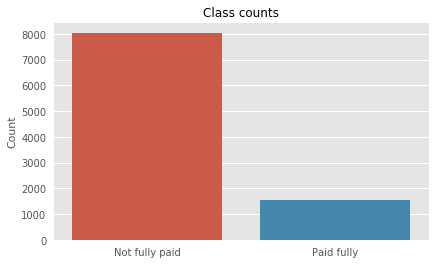

In [61]:
# Get number of positve and negative examples
pos = df[df["not_fully_paid"] == 1].shape[0]
neg = df[df["not_fully_paid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
sns.countplot(df["not_fully_paid"])
plt.xticks((0, 1), ["Not fully paid", "Paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts");

<h3 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Data Preprocessing</h3>

In [12]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["purpose"], drop_first=True)
df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0,1,0,0,0,0,0


In [31]:
# Convert dataframe into features and labels nd-arrays
X = df.loc[:, df.columns != "not_fully_paid"].values
y = df.loc[:, df.columns == "not_fully_paid"].values.flatten()

# Split the data into train and test using 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7662, 18), (7662,), (1916, 18), (1916,))

In [42]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
print(f"\033[1m\033[94mSum of null values in training data: {np.isnan(X_train).sum()}")
print(f"Sum of null values in test data: {np.isnan(X_test).sum()}")

Sum of null values in training data: 0
Sum of null values in test data: 0


In [45]:
# Standardize the data
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train) 
X_test = std.transform(X_test)

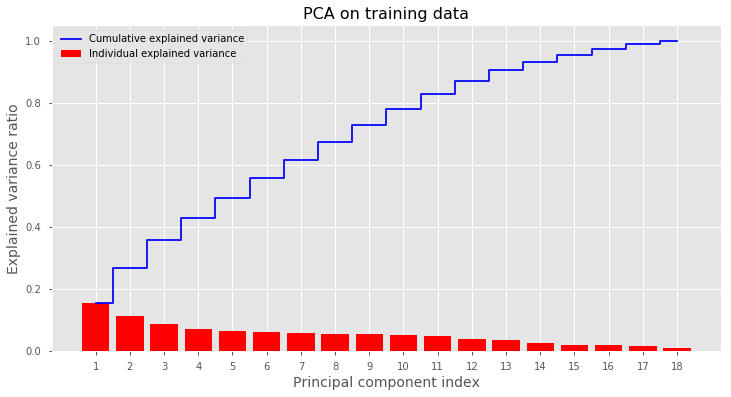

In [61]:
# Build PCA using standarized trained data
pca = PCA(random_state=123, svd_solver="full")
pca.fit(X_train)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 19), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 19), cum_var_exp, where="mid", label="Cumulative explained variance", color="blue")
plt.xticks(range(1, 19))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

In [64]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)

Original shape: (7662, 18) (7662,)
Upsampled shape: (12872, 18) (12872,)


<h3 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Modeling</h3>

In [89]:
# Build base learners
base_learners = {"random_forest": RandomForestClassifier(n_estimators=500,
                                                         max_features=0.25,
                                                         criterion="entropy"),
                 "logistic_regression": LogisticRegression(C=1.5,
                                                           penalty="l1",
                                                           fit_intercept=True),
                 "extra_tree": ExtraTreesClassifier(n_estimators=1000,
                                                    max_features="log2",
                                                    criterion="entropy"),
                 "gradient_boosting": GradientBoostingClassifier(loss="deviance",
                                                                 learning_rate=0.1,
                                                                 n_estimators=500,
                                                                 max_depth=3,
                                                                 max_features="log2"),
                 "svc": SVC(C=0.01, gamma=0.1, kernel="poly", degree=3, coef0=10, probability=True)}

# Build meta learner --


def train_ensemble(base_learners, X_train, y_train):
    for name, classifier in base_learners.items():
        print(f"\033[1m\033[94mTraining {name} classifier...")
        classifier.fit(X_train, y_train)
        print(f"\033[1m\033[92mDone")
        
        
def predict_ensemble(base_learners, X_test):
    base_learners_names = base_learners.keys()
    prob_matrix = np.zeros((X_test.shape[0], len(base_learners)))
    prob_matrix = pd.DataFrame(prob_matrix)
    prob_matrix.columns = base_learners_names
    
    for name, classifier in base_learners.items():
        prob_matrix.loc[:, name] = classifier.predict_proba(X_test)[:, 1]
        
    return prob_matrix.mean(axis=1)

In [95]:
train_ensemble(base_learners, X_train_u, y_train_u)

Training random_forest classifier...
Done
Training logistic_regression classifier...
Done
Training extra_tree classifier...
Done
Training gradient_boosting classifier...
Done
Training svc classifier...
Done


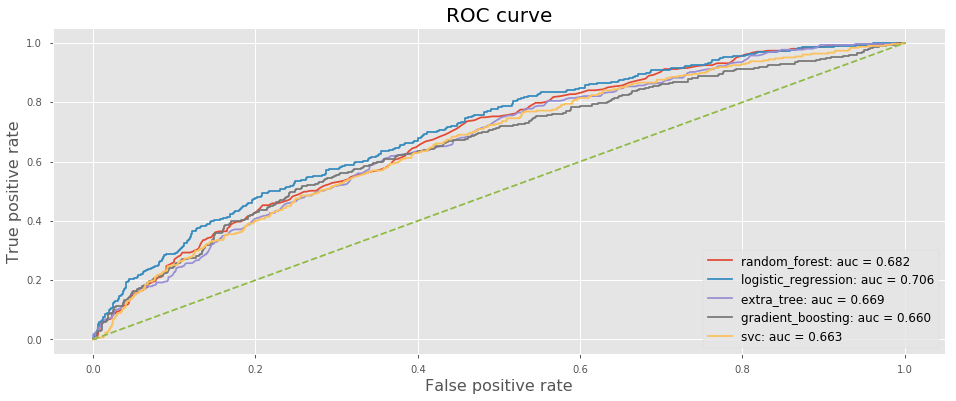

In [96]:
plot_roc(base_learners, X_test, y_test)

In [97]:
roc_auc_score(y_test, predict_ensemble(base_learners, X_test))

0.6960966712081674

In [108]:
rf = make_pipeline(RandomForestClassifier(class_weight="balanced",
                                          random_state=123))

hyperparam_grid = {
    "randomforestclassifier__n_estimators": [10, 50, 100, 500],
    "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
    "randomforestclassifier__min_samples_leaf": [1, 3, 5],
    "randomforestclassifier__criterion": ["gini", "entropy"]}

gs_rf = GridSearchCV(rf,
                     hyperparam_grid,
                     scoring="f1",
                     cv=10,
                     n_jobs=-1)

gs_rf.fit(X_train_u, y_train_u)

for hyperparam in gs_rf.best_params_.keys():
    print(f"{hyperparam[hyperparam.find('__') + 2:]}: {gs_rf.best_params_[hyperparam]}")

print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")

KeyboardInterrupt: 

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion</h2><br>